# FEM results

## Setup

In [1]:
%matplotlib inline
import os
import glob
import sys
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import constants
from PIL import Image

A custom plot style is loaded through a style-sheet, which is based on the seaborn libary.

In [2]:
# set custom matplotlib rc file 
url_rcfile = 'https://raw.githubusercontent.com/TheFerry10/ml-parameter-identification/master/seaborn-custom-style.mplstyle'
mpl.style.use(url_rcfile)

# Uncomment the following lines, if you wish to use latex fonts in matplotlib
# figures. The first line installs latex fonts, while the second line activates
# the fonts in the matplotlib rc file

#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
mpl.rcParams['text.usetex'] = True

Besides this, a few helper functions are imported, which are defined outside the Jupyter notebook. 

In [3]:
from plotstandards import *
from plotlabels import Labels

In [4]:
def convert_centimeters_to_inches(length_in_centimeters):
    return length_in_centimeters * constants.centi / constants.inch

In [5]:
TEXTWIDTH_IN_CENTIMETERS = 16
plotStyle = CustomPlotStyle(textwidth_in_inches=convert_centimeters_to_inches(TEXTWIDTH_IN_CENTIMETERS))
plotLabels = Labels()

Set input and output directory

In [6]:
INPUT_DIR = 'input-data'
OUTPUT_DIR = 'output-data'

PATH_TO_FIGURES =  os.path.join(OUTPUT_DIR, 'fig/')
if not os.path.isdir(PATH_TO_FIGURES):
    os.mkdir(PATH_TO_FIGURES)

In [7]:
def split_file_name(file_name, seperator='.',append_string=''):
    subname = ''
    name, extension = os.path.splitext(os.path.basename(file_name))
    if len(name.split(seperator)) > 1:
        name, *subnames = name.split(seperator)
        subname = '-' + '-'.join(subnames)
    subname +=  append_string
    return name + subname + extension
    

def split_string_by_seperator(string, seperator='-'):
    return string.split(seperator)

def transform_list_to_dict(input_list):
    reshaped_array = np.array(input_list).reshape(len(input_list)//2, 2)
    return dict(reshaped_array)

class TimeStep(object):
    def __init__(self,file_dir):
        file_name = os.path.join(file_dir, 'time2index.csv')
        df = pd.read_csv(file_name)
        self.index2time_fun = StandardFunctions().poly1
        self.index2time_parameter, _ = optimize.curve_fit(self.index2time_fun,df['step'].values,df['time'].values)
        
    def time_step_to_time(self,time_step, time_shift=5e3):
        return self.index2time_fun(time_step,*self.index2time_parameter) - time_shift

In [8]:
def get_file_root(path_to_file):
    file_root, extension = os.path.splitext(os.path.basename(path_to_file))
    return file_root

In [9]:
def get_re_file_root_from_parameters(parameters_in_file_root,seperator='-'):
    return seperator.join([parameter + seperator + '*' for parameter in parameters_in_file_root])

In [10]:
class Timestep(object):
    def __init__(self,timestep_to_time):
        self.timestep_to_time = timestep_to_time
        self.time_shift = 5e3
        
    def get_time_from_timestep(self, timestep):
        return self.timestep_to_time['time'][timestep] - self.time_shift

In [11]:
def get_concat_h(im1, im2):
    background_color = (255, 255, 255)
    dst = Image.new('RGB', (im1.width + im2.width, im1.height),background_color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    background_color = (255, 255, 255)
    dst = Image.new('RGB', (im1.width, im1.height + im2.height),background_color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [12]:
def get_file_root_from_parameters(parameters):
    value_pairs = [key + '-' + parameters[key] for key in parameters.keys()]
    file_root = '-'.join(value_pairs)
    return file_root

In [13]:
def get_plot_title(parameters):
    injection_time_in_hours = time_conversion.get_time_from_timestep(int(parameters['timestep'])) / constants.hour
    injection_pressure_in_kPa = parameters['pressure']
    plot_title = r'$\bar{p}_{in}$' + ' = {} kPa, $t$ = {:3.1f} h'.format(injection_pressure_in_kPa, injection_time_in_hours)
    return plot_title

In [14]:
class PlotCollection(object):
    def __init__(self, initial_parameters, column, row):
        self._parameters = initial_parameters
        self._column = column
        self._row = row
        self._nrows = [len(row[key]) for key in row.keys()][0]
        self._ncols = [len(column[key]) for key in column.keys()][0]
        self.file_extension = '.png'
        self.file_dir_to_images = ''
    
    def get_figure(self, **plot_parameters):
        fig, ax = plt.subplots(nrows=self._nrows, ncols=self._ncols, **plot_parameters)
        return fig, ax
        
    def update_parameters(self, ncol, nrow):
        self._parameters.update({key:self._column[key][ncol] for key in self._column.keys() if key not in self._row.keys()})
        self._parameters.update({key:self._row[key][nrow] for key in self._row.keys() if key not in self._column.keys()})
        self._parameters.update({key: [self._column[key],self._row[key]][nrow][ncol] for key in self._column.keys() if key in self._row.keys()})
    
    def plot(self, **plot_parameters):
        fig, ax = self.get_figure(**plot_parameters)
        for nrow in range(self._nrows):
            for ncol in range(self._ncols):
                self.update_parameters(ncol, nrow)
                file_path = os.path.join(self.file_dir_to_images, get_file_root_from_parameters(self._parameters) + self.file_extension)
                ax[nrow,ncol].imshow(Image.open(file_path))
                ax[nrow,ncol].title.set_text(get_plot_title(self._parameters))
                ax[nrow,ncol].axis('off')
        plt.tight_layout(h_pad=2,w_pad=5)

In [15]:
def get_cropped_image(img):
    box = img.getbbox()
    img = img.crop(box)
    return img

In [16]:
def draw_background_to_image(img, background_color=0):
    background = Image.new('RGB', img.size,background_color)
    background.paste(img,(0,0),img)
    return background

In [17]:
def center_image_to_reference_image(img, img_ref, background_color_in_image=0):
    background = Image.new('RGB', (img_ref.width, img.height),background_color_in_image)
    center = (int((img_ref.width - img.width)/2),0)
    background.paste(img, center)
    return background

In [18]:
def scale_image(img,scale):
    new_size = tuple([np.int(scale*img_dimension) for img_dimension in img.size])
    return img.resize(new_size)

In [19]:
def get_concat_grid_and_legend(img_grid_plot,img_legend,grid_to_legend_rato=0.8):
    img_scale = grid_to_legend_rato * img_grid_plot.width / img_legend.width
    img_legend = scale_image(img_legend,img_scale)
    img_legend = center_image_to_reference_image(img_legend,img_grid_plot,(255,255,255))
    return get_concat_v(img_grid_plot,img_legend)

# Crop images

In the first step, the data needs to be analyzed. Which data is available? In which form are the file names represented? 

Preprocessing of the data: Crop the image files automatically and save the results. This could also be done for the legend

In [20]:
file_extension_images = '.png'
rgb_white = tuple([int(color*255) for color in mpl.colors.to_rgb('white')])
keys_in_snapshot_files = ['field', 'pressure', 'timestep']
keys_in_legend_files = ['legend']

### Snapshots

In [21]:
re_base_name_snapshots = get_re_file_root_from_parameters(keys_in_snapshot_files) + file_extension_images
file_paths_to_snapshots = glob.glob(os.path.join(INPUT_DIR, re_base_name_snapshots))

### Legend

In [22]:
re_base_name_legend = get_re_file_root_from_parameters(keys_in_legend_files) + file_extension_images
file_paths_to_legends = glob.glob(os.path.join(INPUT_DIR, re_base_name_legend))

### Crop all files 

In [23]:
file_paths_to_images = file_paths_to_snapshots + file_paths_to_legends

In [24]:
for file_path in file_paths_to_images:
    img = get_cropped_image(Image.open(file_path))
    draw_background_to_image(img, background_color=rgb_white).save(os.path.join(PATH_TO_FIGURES, os.path.basename(file_path)))

# Plot snapshots in grid

- Time step to time

In [25]:
timestep_to_time = pd.read_csv(os.path.join(INPUT_DIR, 'time2index.csv'),
                               index_col='timestep')
time_conversion = Timestep(timestep_to_time)

## Specify parameters for grid plots

In [26]:
parameters = {key:[] for key in keys_in_snapshot_files}
pressures = ['50', '100','150', '200']
timesteps = [str(timestep).zfill(4) for timestep in [10,20,30,60]]

- Saturation distributions (4x4)

In [27]:
parameters_saturation = {key:[] for key in keys_in_snapshot_files}
parameters_saturation['field'] = 'saturation'
column_saturation = {'pressure':pressures[:3]}
row_saturation = {'timestep':timesteps[1:]}

- Viscosity distributions (4x4)

In [28]:
parameters_viscosity = {key:[] for key in keys_in_snapshot_files}
parameters_viscosity['field'] = 'viscosity'
column_viscosity = {'pressure':pressures[:3]}
row_viscosity = {'timestep':timesteps[1:]}

- Velocity distributions (2x2)

In [29]:
parameters_velocity = {key:[] for key in keys_in_snapshot_files}
parameters_velocity['field'] = 'velocity'
parameters_velocity['pressure'] = '150'
column_velocity = {'timestep':timesteps[:2]}
row_velocity = {'timestep':timesteps[2:]}

- Plot distributions in grid style and save figures

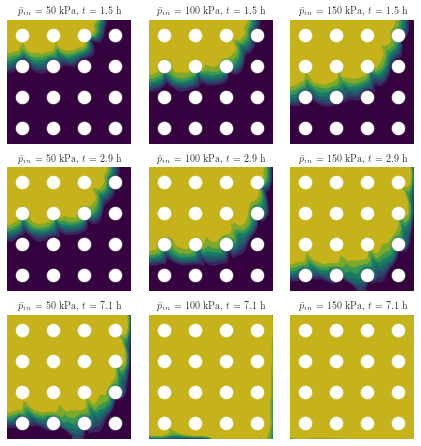

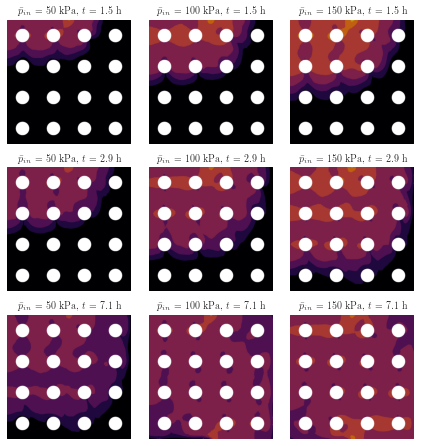

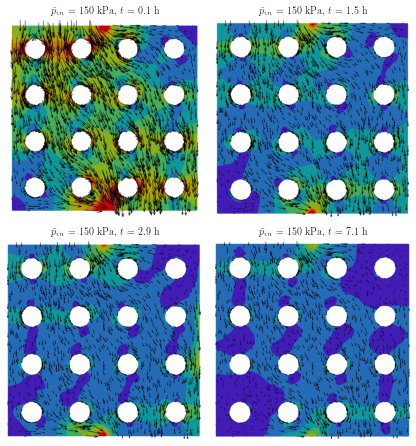

In [30]:
for (parameters,column,row) in zip([parameters_saturation,parameters_viscosity,parameters_velocity],
                                   [column_saturation,column_viscosity,column_velocity],
                                   [row_saturation,row_viscosity,row_velocity]):
    plot_collection = PlotCollection(parameters, column, row)
    plot_collection.file_dir_to_images = PATH_TO_FIGURES
    plot_collection.file_extension = '.png'
    plot_parameters = {"figsize": set_figsize(aspect_ratio=1.0)}
    plot_collection.plot(**plot_parameters)
    fig = plt.gcf()
    save_fig(file_name=f"grid-{parameters['field']}", output_dir=PATH_TO_FIGURES, dpi=300)

# Combine snapshots and color legend

Next, the ensambles should be plotted. To this end, the cropped image files related to the same legend and variable are plotted together. For better comparision, the cropped results are imported into a user-specific grid. Information corresponding to each snapshot are adressed through the plot titles of the subplots. This procedure can be easily automated, such that each subtitle corresponds to information obtained from the file name of the subplot. 

In [31]:
distribution_names = [parameters['field'] for parameters in [parameters_saturation,parameters_viscosity,parameters_velocity]]
grid_to_legend_rato = 0.8

In [33]:
for distribution_name in distribution_names:
    file_name_legend = os.path.join(PATH_TO_FIGURES, f'legend-{distribution_name}.png')
    file_name_grid_plot = os.path.join(PATH_TO_FIGURES, f'grid-{distribution_name}.png')
    file_name_grid_plot_and_legend = os.path.join(PATH_TO_FIGURES,f'grid-legend-{distribution_name}.png')
                                                  
    get_concat_grid_and_legend(Image.open(file_name_grid_plot),
                               Image.open(file_name_legend),
                               grid_to_legend_rato=0.8).save(file_name_grid_plot_and_legend)

![title](output-data/fig/grid-legend-saturation.png)
![title](output-data/fig/grid-legend-viscosity.png)
![title](output-data/fig/grid-legend-velocity.png)